## Wine Embeddings and a Wine Recommender

### 1. Introduction

One of the cornerstones of every chapter of the Robosomm series has been to extract descriptors from professional wine reviews, and to convert these into quantitative features. In doing so, we want to put ourselves in the shoes of a blind taster and extract only those descriptors that could be derived without knowing what the wine actually is. 

In this notebook, we will combine a couple of best-practice approaches highlighted in the existing literature on this subject and create an embedding for each wine review. We will use this to build a simple wine recommender.

In [75]:
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

### 1. The Raw Dataset

The raw dataset consists of roughly 150,000 wine reviews from www.winemag.com. These reviews span about 20 years and a few dozen grape varieties. These reviews have been scraped one variety at a time, so the first step is to consolidate the various CSV files with the results of the scraping exercise.

In [206]:
base_location = r'C:\Users\roald\Documents\data_science_projects\wine_styles_data'

i = 0
for file in os.listdir(base_location):
    file_location = base_location + '/' + str(file)
    if i==0:
        wine_dataframe = pd.read_csv(file_location, encoding='latin-1')
        i+=1
    else:
        df_to_append = pd.read_csv(file_location, encoding='latin-1', low_memory=False)
        wine_dataframe = pd.concat([wine_dataframe, df_to_append], axis=0)

wine_dataframe.drop_duplicates(subset=['Name'], inplace=True)
print(wine_dataframe.shape)

(181303, 22)


### 2. Extracting Wine Descrpitors

To begin this analysis, we need to extract descriptors from our reviews and create a categorization of these descriptors at various levels of specificity. Here, I drew inspiration from some of the great work by Bernard Chen and others on the Computational Wine Wheel (https://www.springerprofessional.de/en/the-computational-wine-wheel-2-0-and-the-trimax-triclustering-in/10290536). 

Descriptors are extracted in a few steps, outlined in the cells below: first, all the wine reviews are conslidated into one large corpus. They are then tokenized into sentences.

In [91]:
reviews_list = list(wine_dataframe['Description'])
reviews_list = [str(r) for r in reviews_list]
full_corpus = ' '.join(reviews_list)
sentences_tokenized = sent_tokenize(full_corpus)

print(sentences_tokenized[:5])

["Made in partnership with Alpha Omega Winery's Jean Hoefliger, this famous namesake wine embraces the fullness that is Napa Valley concentration and sunny richness, showing baked plum, cinnamon and generous tannin and oak.", 'The backbone is plush and lush in texture, evolving as it opens in the glass.', 'Enjoy this in good time; should show best 2024â\x80\x932034.', 'Cabernet Sauvignon from esteemed Cold Creek Vineyard makes up the backbone of this wine.', 'Intoxicating aromas of assorted dried herbs, graphite, spice, tea leaf, coffee and black cherry are followed by tightly wound dark fruit flavors.']


Next, the text in each sentence is normalized (tokenize, remove punctuation and remove stopwords).

In [92]:
stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

# sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

Not all of the terms we are interested in are single words. Some of the terms are phrases, consisting of two (or more!) words. An example of this might be 'high tannin'. We can use gensim's Phrases feature to extract all the most relevant bi- and tri-grams from our corpus.

In [93]:
phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

Next, we will extract the most common words and rank these by how frequently they appear.

In [94]:
word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')

Now for the most important part: leveraging existing wine theory, the work of others like Bernard Chen, wine descriptor mappings and the UC Davis wine wheel, the top 5000 most frequent wine terms were reviewed to (i) determine whether they are a descriptor that can be derived by blind tasting, and (ii) whether they are informative (judgments like 'tasty' and 'great' are not considered to be informative). The roughly 1000 descriptors that remain were then mapped onto a normalized descriptor, a category and a class:

In [95]:
descriptor_mapping = pd.read_csv('descriptor_mapping.csv').set_index('raw descriptor')
descriptor_mapping.head(10)

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid
airi,airy,light_bodied,body
alcohol_heat,hot,high_alcohol,alcohol
allspic,allspice,baking_spices,spice
almond,almond,nutty,nutty
almond_past,almond,nutty,nutty
alongsid_finegrain,finegrained_tannin,low_tannin,tannin


Next, any terms in the corpus that appear in the overview above are mapped onto the 'level_3' (the most specific) layer in the table.

In [96]:
def return_mapped_descriptor(word):
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return word

normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        normalized_sentence.append(str(normalized_word))
    normalized_sentences.append(normalized_sentence)

### 3. From Wine Descriptors to Word Embeddings

We can now proceed to train a Word2Vec model on our normalized and descriptor-mapped corpus. This will allow us to get a word embedding for every term in the corpus. In order to reduce the overall size of the corpus, we will exclude any terms that appear fewer than 5 times across all the wine reviews.

In [97]:
wine_word2vec_model = Word2Vec(normalized_sentences, size=300, min_count=5, iter=15)
print(wine_word2vec_model)

wine_word2vec_model.save('wine_word2vec_model.bin')

Word2Vec(vocab=19924, size=300, alpha=0.025)


Let's take a closer look at our trained Word2Vec model - what wine descriptors are most similar to the word 'peach'?

In [98]:
wine_word2vec_model.wv.most_similar(positive='peach', topn=10)

[('stone_fruit', 0.7766212224960327),
 ('honeydew', 0.7047280669212341),
 ('nectarine', 0.675035834312439),
 ('mango', 0.65788334608078),
 ('yellowpeach', 0.6536487340927124),
 ('pear', 0.6373701095581055),
 ('apple', 0.6313578486442566),
 ('tangerine', 0.6175214052200317),
 ('peach_papaya', 0.6129261255264282),
 ('kiwi', 0.6106382608413696)]

Excellent! These words are all relatively similar to the word peach. It seems that our Word2Vec model is working well. 

### 4. From Word Embeddings to Wine Review Embeddings

Now, we need to find a way to create a single embedding for each wine review, combining all the relevant word embeddings contained within it.

First, we will extract a set of mapped & normalized descriptors from each wine review. Unlike when we were training our Word2Vec model (when in-between words with semantic meaning could help create more accurate embeddings), we will remove any descriptors that do not feature in our list of 1000 curated descriptors. 

In [100]:
wine_reviews = list(wine_dataframe['Description'])

def return_descriptor_from_mapping(word):
    if word in list(descriptor_mapping.index):
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in wine_reviews:
    normalized_review = normalize_text(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

Not all descriptors are equally distinctive - 'fruity', for instance, is likely to appear very frequently across all wine reviews, whereas 'licorice' is much less common. In computing our 'review' embedding, we want to give a higher weighting to terms that are more infrequent in relative terms. We will do this by multiplying each word embedding by a TF-IDF (term frequency inverse document frequency) weighting. This takes into consideration both the frequency of each term across all reviews, as well as the number of descriptors in each wine review. 

In [101]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in descriptorized_reviews:
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

wine_dataframe['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
wine_dataframe['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
wine_dataframe['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

wine_dataframe.reset_index(inplace=True)
wine_dataframe.head()

,index,Unnamed: 0,Alcohol,Appellation,Bottle Size,Category,Country,Date Published,Description,Designation,...,Reviewer,Reviewer Twitter Handle,Subregion,User Avg Rating,Variety,Vintage,Winery,normalized_descriptors,review_vector,descriptor_count
0,0,0.0,14.9%,"Napa Valley, Napa, California, US",750 ml,Red,US,7/1/2019,Made in partnership with Alpha Omega Winery's ...,MR,...,Virginie Boone,@vboone,Napa Valley,Not rated yet [Add Your Review],Bordeaux-style Red Blend,2014.0,Michel Rolland Napa Valley,"[concentrated, rich, baked, plum, cinnamon, oa...","[[-1.6203853, 1.0555973, 5.058047, -0.07586262...",8
1,1,1.0,14.5%,"Columbia Valley (WA), Columbia Valley, Washing...",750 ml,Red,US,7/1/2019,Cabernet Sauvignon from esteemed Cold Creek Vi...,NaN,...,Sean P. Sullivan,@wawinereport,Columbia Valley (WA),Not rated yet [Add Your Review],Bordeaux-style Red Blend,2014.0,21 Grams,"[dry, herb, graphite, spice, tea, coffee, cher...","[[-0.69587994, -0.57188, 1.6246213, -2.5362446...",12
2,2,2.0,13.6%,"Paso Robles, Central Coast, California, US",750 ml,Red,US,7/1/2019,Lush black-raspberry and black-plum aromas com...,Nikiara,...,Matt Kettmann,@mattkettmann,Paso Robles,Not rated yet [Add Your Review],Bordeaux-style Red Blend,2016.0,Le Vigne,"[lush, plum, incense, umami, white_pepper, roa...","[[-1.2084105, -2.9379678, 0.7938164, -0.132832...",8
3,3,3.0,14.8%,"Adelaida District, Central Coast, California, US",750 ml,Red,US,7/1/2019,"Bright aromas of blackberry, violet and cedar ...",NaN,...,Matt Kettmann,@mattkettmann,Adelaida District,Not rated yet [Add Your Review],"Meritage, Bordeaux-style Red Blend",2016.0,Brecon Estate,"[bright, blackberry, violet, cedar, tight, ber...","[[-1.9579656, -3.495587, 3.1620667, -1.6078877...",8
4,4,4.0,14.5%,"Aconcagua Valley, Chile",750 ml,Red,Chile,7/1/2019,Spicy cherry and coffee aromas drive a traditi...,Capa,...,Michael Schachner,@wineschach,NaN,Not rated yet [Add Your Review],Bordeaux-style Red Blend,2014.0,Conde de VelÃ¡zquez,"[spice, cherry, coffee, dry, choppy, cassis, c...","[[-2.5236423, -2.0405033, 2.8112369, -2.394661...",10


To summarize, we generate a single vector for each wine review by going through the following steps:

1. Normalize words in wine review (remove stopwords, punctuation, stemming)
2. Enhance the set of normalized words with phrases (bi-grams and tri-grams)
3. Apply mapping of wine terms to each review, keeping only those mapped phrases & words that have been deemed relevant and mapping these to our curated level 3 descriptors
4. Retrieve the Word2Vec word embedding for each mapped term in the review
5. Weight each word embedding in the wine review with a TF-IDF weighting
6. Sum the word embeddings within each wine review to create a single vector representation of the wine review

### 5. Exploring our Wine Review Vectors

#### 5.1 Similarities Between Grape Varieties

Now that we have a vector representation of each wine review, we can start to explore potential uses of this data. Before we turn our attention to the creation of a wine recommendation engine, we will take a look at the similarities between grape varieties. We will do this by taking the average of all wine review vectors for each grape variety, compressing them into two dimensions using PCA (Principal Component Analysis) and then producing a visual mapping.

In [118]:
# first, let's eliminate any review with fewer than 5 descriptors from our dataset
wine_reviews_mincount = wine_dataframe.loc[wine_dataframe['descriptor_count'] > 5]
wine_reviews_mincount.reset_index(inplace=True)

variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache', 'CarmenÃ¨re': 'Carmenere',
                    'GrÃ¼ner Veltliner': 'Gruner Veltliner', 'TorrontÃ©s': 'Torrontes', 
                   'RhÃ´ne-style Red Blend': 'Rhone-style Red Blend', 'AlbariÃ±o': 'Albarino',
                  'GewÃ¼rztraminer': 'Gewurztraminer', 'RhÃ´ne-style White Blend': 'Rhone-style White Blend'}

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_reviews_clean = wine_reviews_mincount.copy()
wine_reviews_clean['Variety'] = wine_reviews_clean['Variety'].apply(consolidate_varieties)

def subset_wine_vectors(list_of_varieties):
    wine_variety_vectors = []
    for v in list_of_varieties:
        one_var_only = wine_reviews_clean.loc[wine_reviews_clean['Variety'] == v]
        review_arrays = one_var_only['review_vector'].apply(lambda x: x[0])
        average_variety_vec = np.average(review_arrays)
        wine_variety_vector = [v, average_variety_vec]
        wine_variety_vectors.append(wine_variety_vector)
    return wine_variety_vectors

def pca_wine_variety(list_of_varieties):
    wine_var_vectors = subset_wine_vectors(list_of_varieties)
    pca = PCA(n_components=2)
    pca.fit([w[1] for w in wine_var_vectors])  
    pca_dataset = pca.fit_transform([w[1] for w in wine_var_vectors])
    pca_dataframe = pd.DataFrame(pca_dataset, columns=['pca_1', 'pca_2'])
    pca_dataframe.index = [w[0] for w in wine_var_vectors]
    # print(pca_dataframe)
    return pca_dataframe

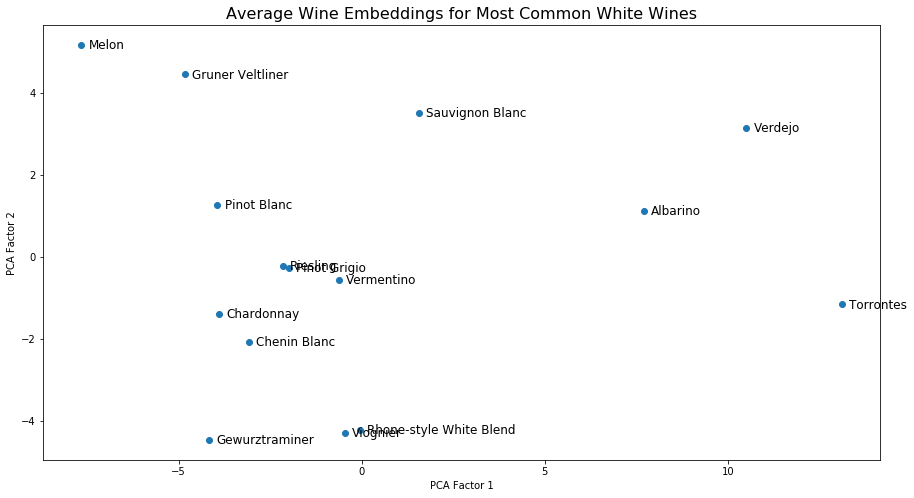

In [199]:
most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
                        'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albarino', 'Pinot Blanc', 'Verdejo',
                        'Torrontes', 'Vermentino', 'Melon', 'Gewurztraminer', 'Rhone-style White Blend']

pca_w_dataframe = pca_wine_variety(most_common_whites)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common White Wines', fontsize=16)
plt.show()

At a glance, it appears that the dryer grape varieties (Albarino, Verdejo, Sauvignon Blanc, Melon) are more on the top half of this plot. Slightly sweeter and full-bodied grape varieties such as Chardonnay, Chenin Blanc and Viognier feature on the bottom half of this plot. It is noteworthy how close together Pinot Grigio and Riesling are in the diagram above. It is worth noting that we cannot capture all the variation between these grape varieties in two dimensions, so the above plot is somewhat imperfect. Nevertheless, let's go through the same exercise for the red grape varieties to see what we can learn.

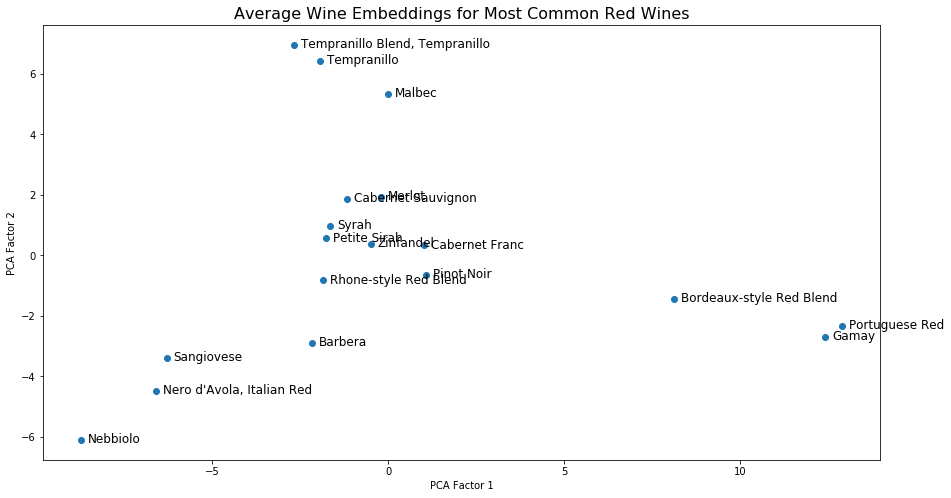

In [204]:
most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
                         'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
                         'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay','Tempranillo Blend, Tempranillo', 'Petite Sirah',
                        'Barbera', "Nero d'Avola, Italian Red"]

pca_r_dataframe = pca_wine_variety(most_common_reds)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_r_dataframe['pca_1'], y=pca_r_dataframe['pca_2'])
for i, txt in enumerate(pca_r_dataframe.index):
    plt.annotate(txt, (list(pca_r_dataframe['pca_1'])[i]+0.2, list(pca_r_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common Red Wines', fontsize=16)
plt.show()

Plotting the most common red wines, we can see that the Italian grape varieties all sit in the bottom left-hand quadrant of the plot above. It is also noteworthy that Merlot and Cabernet Sauvignon are so close together - this is not surprising, since these two grape varieties are genetically very similar. It is somewhat surprising that Gamay (which produces light-bodied reds that are, in my experience, somewhat similar to Pinot Noir) is way off on the right-hand side of the graph, relatively close to Bordeaux-style Red Blends. 

#### 5.2 Wine Recommender

We can also use our wine review vectors to make wine suggestions. We can do this by using a nearest neighbors model, which calculates the cosine distance between various wine review vectors. The vectorized wine reviews that lie closest to one another are returned as suggestions.

In [ ]:
input_vectors = list(wine_reviews_mincount['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]
input_vectors_listed = [a[0] for a in input_vectors_listed]

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

First, let's see what suggestions are returned when we feed this nearest neighbors algorithm a wine we like. To demonstrate this, we have chosen a random wine from our dataset - a Pinot Noir from Santa Barbara, California.

In [167]:
name_test = "Point & Line 2016 John Sebastiano Vineyard Reserve Pinot Noir (Sta. Rita Hills)"

wine_test_vector = wine_reviews_mincount.loc[wine_reviews_mincount['Name'] == name_test]['review_vector'].tolist()[0]
distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=9)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine = wine_reviews_mincount.loc[wine_reviews_mincount['Name'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
print('_________')

n = 1
for d, i in zip(distance_list, indice_list):
    wine_name = wine_reviews_mincount['Name'][i]
    wine_descriptors = wine_reviews_mincount['normalized_descriptors'][i]
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('')
    n+=1

Wine to match: Point & Line 2016 John Sebastiano Vineyard Reserve Pinot Noir (Sta. Rita Hills)
The original wine has the following descriptors: ['dry', 'flower', 'sage', 'elegant', 'tarragon', 'pepper', 'tangy', 'cranberry', 'light_bodied']
_________
Suggestion 1 : Scheid 2015 Doctor's Vineyard Pinot Noir (Santa Lucia Highlands) with a cosine distance of 0.067
This wine has the following descriptors: ['light_bodied', 'sage', 'spice', 'depth', 'cranberry', 'earth', 'herb', 'dry', 'sage', 'pepper', 'zesty', 'fruit']

Suggestion 2 : Hug 2016 Steiner Creek Pinot Noir (San Luis Obispo County) with a cosine distance of 0.069
This wine has the following descriptors: ['fresh', 'raspberry', 'thyme', 'pepper', 'rosemary', 'sage', 'dry', 'sage', 'mint', 'forest_floor', 'light_bodied', 'cranberry_pomegranate', 'tangy']

Suggestion 3 : Ojai 2014 Pinot Noir (Santa Barbara County) with a cosine distance of 0.074
This wine has the following descriptors: ['light_bodied', 'rose', 'ripe', 'cranberry', 's

Great! It appears that the wines being returned as suggestions are also California Pinot Noir wines. Interestingly, many of these wines are even from the Santa Barbara area. The distinctive profile of these wines appears to be captured well by our wine recommender model. The most surprising suggestion returned by our model is a Washington State Cabernet Sauvignon. This cold-climate Cabernet appears have many of the same descriptors (herbs, flower, cherry) as our original (warm-climate) Pinot Noir wine.

Finally, we can also use our wine recommender model to return a suggestion for a wine based on a list of input descriptors. This could be helpful when looking for similarities between wines, or when searching for a particular flavor profile. 

In [173]:
def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
    weighted_review_terms = []
    for term in list_of_descriptors:
        if term not in dict_of_tfidf_weightings:
            if term not in descriptor_mapping.index:
                print('choose a different descriptor from', term)
                continue
            else:
                term = descriptor_mapping['normalized'][term]
        tfidf_weighting = dict_of_tfidf_weightings[term]
        word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
        weighted_word_vector = tfidf_weighting * word_vector
        weighted_review_terms.append(weighted_word_vector)
    review_vector = sum(weighted_review_terms)
    
    distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
    distance_list = distance[0].tolist()[1:]
    indice_list = indice[0].tolist()[1:]

    n = 1
    for d, i in zip(distance_list, indice_list):
        wine_name = wine_reviews_mincount['Name'][i]
        wine_descriptors = wine_reviews_mincount['normalized_descriptors'][i]
        print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
        print('This wine has the following descriptors:', wine_descriptors)
        print('')
        n+=1
    
descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

Suggestion 1 : Matetic 2009 EQ Sauvignon Blanc (San Antonio) with a cosine distance of 0.136
This wine has the following descriptors: ['clean', 'citrus', 'nettle', 'bell_pepper', 'fresh', 'snappy', 'grass', 'tropical_fruit', 'fruit', 'lime', 'crisp']

Suggestion 2 : Koyle 2011 Koyle Costa Sauvignon Blanc (Colchagua Costa) with a cosine distance of 0.138
This wine has the following descriptors: ['snappy', 'bell_pepper', 'tangerine', 'grass', 'crisp', 'citrus', 'dry', 'lime', 'grapefruit', 'lemon', 'grapefruit', 'linear', 'high_acid']

Suggestion 3 : 1+1=3 NV Brut Sparkling (Cava) with a cosine distance of 0.138
This wine has the following descriptors: ['dust', 'citrus', 'fruit', 'zesty', 'fresh', 'lime', 'grass', 'fresh', 'apple', 'lime']

Suggestion 4 : Emiliana 2014 Novas Gran Reserva Sauvignon Blanc (San Antonio) with a cosine distance of 0.139
This wine has the following descriptors: ['grass', 'green', 'citrus', 'snappy', 'herb', 'grass', 'lime', 'tarragon', 'racy', 'vegetal', 'fres

When in the mood for a wine that is complex, acidic, fresh, grassy and limey, it appears that we should try a Chilean Sauvignon Blanc - 4 out of the 5 wines returned as suggestions fall in this category. Alternatively, a glass of Cava from Spain might hit the spot too.

#### 6. Conclusion

This notebook is an exercise in two parts. In the first part, we develop a robust method to generate a 'wine embedding' that captures all relevant information from a wine review, maps it onto a set of curated and standardized descriptors, assigns an embedding to each of these descriptors, weights each descriptor using a TF-IDF score and then aggregates the various descriptor vectors to produce a single 'wine embedding' for the full wine review. In the second part of this notebook, we start to explore ways in which we might use these newly created wine embeddings. One way to do this is through a wine recommender model, which measures the cosine distance between wine embeddings to make suggestions. Based on a few examples, we can see that the suggestions that are returned are remarkably consistent. This is a promising result that suggests there is much potential for wine embeddings to be used for future iterations of this work.